# Grid Study and Sensitivity Analysis

In [12]:
import kelp_param
import kelp3d_objs as k3
import ipyparallel as ipp
import concurrent.futures as cf
import itertools as it
from sympy import divisors
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt

In [13]:
remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()

### Define Constants

In [14]:
from scipy.sparse.linalg import gmres

In [15]:
# Hard-coded parameters
rope_spacing = 5.0 # (m)
zmin, zmax = 0.0, 10.0 # (m)

# Light from above
I0 = 50.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 0 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
tol_abs = 1e-6
tol_rel = 1e-6
maxiter_inner = 200
maxiter_outer = 200
gmres_wrapper = k3.gmres_wrapper

const = (rope_spacing, zmin, zmax, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax,
         tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_wrapper)

# Compare FD & Exact Solution

In [19]:
# Set parameters
a_water = 0.5
b = 0.00
ns = 10
na = 10
kelp_profile='none'

nz_max = 24
nz_list = np.array(divisors(24))
nz_list = nz_list[nz_list>3]

def exp_fun(x, c, a):
    return c*np.exp(-a*x)

# Exact solution (no kelp, no scattering)
exact_results = lv.apply(kelp_param.kelp_calculate,
    a_water,
    b,
    ns,
    na,
    nz_max,
    kelp_profile,
    absorptance_kelp=0.8,
    gmres_flag=False,
    num_scatters=0,
    const=const
).result()

exact_irrad = exact_results['irradiance'].mean(axis=(0,1))

irrad_list = []
abs_err_list = []
rel_err_list = []

# Run scattering cases
for nz in nz_list:
    print("nz={}".format(nz))
    #print("const={}".format(const))
    compute_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns,
        na,
        nz,
        kelp_profile,
        absorptance_kelp=0.8,
        gmres_flag=True,
        num_scatters=0,
        const=const
    ).result()

    irrad = compute_results['irradiance'].mean(axis=(0,1))
    irrad_list.append(irrad)
    
    block_exact_irrad = kelp_param.block_mean(exact_irrad, irrad.shape)
    abs_err = np.mean(np.abs(irrad-block_exact_irrad))
    abs_err_list.append(abs_err)
    rel_err = np.mean(np.abs(irrad-block_exact_irrad)/block_exact_irrad)
    rel_err_list.append(rel_err)

nz=4
nz=6
nz=8
nz=12
nz=24


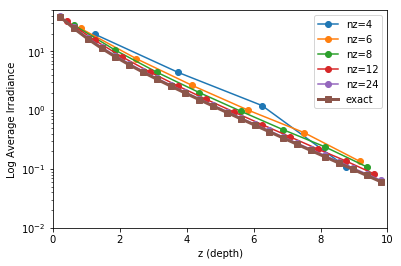

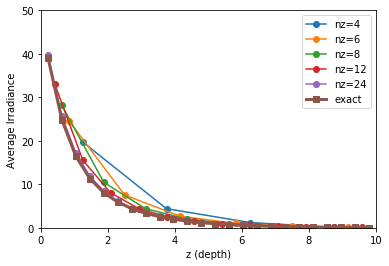

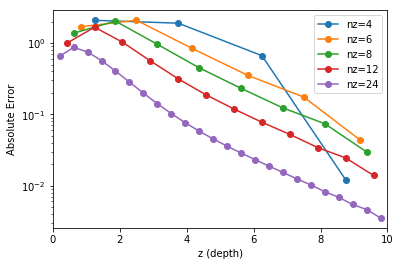

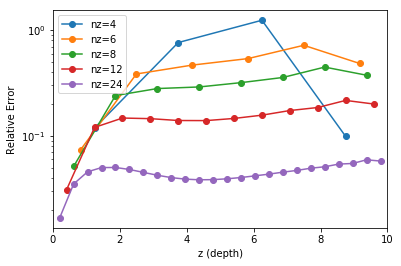

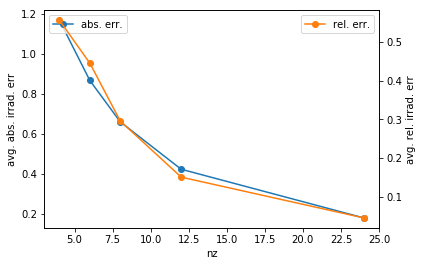

In [75]:
plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    plt.plot(z, irrad, '-o', label='nz={}'.format(nz))
dz = (zmax-zmin)/max(nz_list)
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz_max)
plt.plot(z, exact_irrad, '-s', lw=3, label='exact')
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.ylim(1e-2, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Log Average Irradiance')

plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    plt.plot(z, irrad, '-o', label='nz={}'.format(nz))
dz = (zmax-zmin)/nz_max
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz_max)
plt.plot(z, exact_irrad, '-s', lw=3, label='exact')
plt.yscale('linear')
plt.xlim(zmin, zmax)
plt.ylim(0, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Average Irradiance')


plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    block_exact_irrad = kelp_param.block_mean(exact_irrad, [nz])
    plt.plot(z, np.abs(irrad-block_exact_irrad), '-o', label='nz={}'.format(nz))
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Absolute Error')

plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    block_exact_irrad = kelp_param.block_mean(exact_irrad, [nz])
    plt.plot(z, np.abs((irrad-block_exact_irrad)/block_exact_irrad), '-o', label='nz={}'.format(nz))
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Relative Error')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(nz_list, abs_err_list, 'C0o-', label='abs. err.')
ax1.set_xlabel('nz')
ax1.set_ylabel('avg. abs. irrad. err')
ax1.legend(loc='upper left')
ax2.plot(nz_list, rel_err_list, 'C1o-', label='rel. err.')
ax2.set_ylabel('avg. rel. irrad. err')
ax2.legend(loc='upper right')


plt.show()

# Grid Study

In [ ]:
absorptance_kelp = 0.8 # (%)

# Asymptotics Accuracy

In [ ]:
# Set parameters
a_water = 0.5
b = 0.00
ns = 12
na = 12
nz = 12
kelp_profile='none'
max_scatter = 4

# GMRES
gmres_results = lv.apply(kelp_param.kelp_calculate,
    a_water,
    b,
    ns,
    na,
    nz,
    kelp_profile,
    absorptance_kelp=0.8,
    gmres_flag=True,
    num_scatters=0,
    const=const
).result()

res_list = []
save_list = []

p_kelp = gmres_results['p_kelp']
true_irrad = gmres_results['irradiance']
true_rad = gmres_results['radiance']
true_perceived_irrad = np.sum(p_kelp*true_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1)) / np.pi

# Run scattering cases
for n in range(max_scatter+1):
    print("n={}".format(n))
    #print("const={}".format(const))
    compute_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns,
        na,
        nz,
        kelp_profile,
        absorptance_kelp=0.8,
        gmres_flag=False,
        num_scatters=n,
        const=const
    ).result()

    rad = compute_results['radiance']
    rad_err = np.mean(rad - true_rad)
    irrad = compute_results['irradiance']
    irrad_err = np.abs(true_irrad - irrad).mean(axis=(0,1))
    # Perceived irradiance for each depth layer
    perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    perc_err = np.abs(true_perceived_irrad - perceived_irrad)

    save_vals = {
        'rad_abs_err': rad_err,
        'rad_rel_err': rad_err / np.abs(gmres_results['radiance']),
        'irrad': irrad.mean(axis=(0,1)),
        'irrad_abs_err': irrad_err,
        'irrad_rel_err': irrad_err / np.abs(true_irrad).mean(axis=(0,1)),
        'perceived_irrad': perceived_irrad,
        'perc_abs_err': perc_err,
        'perc_rel_err': perc_err / np.abs(true_perceived_irrad)
    }

    res_list.append(compute_results)
    save_list.append(save_vals)

## Plot Convergence Curves

In [ ]:
zc = np.linspace(zmin, zmax, 101)
true_avg_irrad = true_irrad.mean(axis=(0,1))

In [ ]:
plt.figure()
l, = plt.plot(z, true_avg_irrad, 'o-', label='gmres')
print("gmres: a_eff = {:.2f}, I0={:.2f}".format(true_a_eff, true_c))
plt.plot(zc, exp_fun(zc, true_c, true_a_eff), '--', c=l.get_color())
for n, irrad in enumerate([s['irrad'] for s in save_list]):
    (c, a_eff,),_ = opt.curve_fit(exp_fun, z, irrad, [1, a_water])
    print("n={}: a_eff={:.2f}, I0={:.2f}".format(n, a_eff, c))
    l, = plt.plot(z, irrad, 'o-', label='n={}'.format(n))
    #plt.plot(zc, exp_fun(zc, c, a_eff), '--', c=l.get_color())
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.ylim(1e-2, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Average Irradiance')

plt.figure()
l, = plt.plot(z, true_avg_irrad, 'o-', label='gmres')
plt.plot(zc, exp_fun(zc, true_c, true_a_eff), '--', c=l.get_color())
for n, irrad in enumerate([s['irrad'] for s in save_list]):
    (c, a_eff,),_ = opt.curve_fit(exp_fun, z, irrad, [1, a_water])
    l, = plt.plot(z, irrad, 'o-', label='n={}'.format(n))
    #plt.plot(zc, exp_fun(zc, c, a_eff), '--', c=l.get_color())
plt.yscale('linear')
plt.xlim(zmin, zmax)
plt.ylim(0, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Average Irradiance')

plt.figure()
for n, err in enumerate([s['irrad_abs_err'] for s in save_list]):
    plt.plot(z, err, 'o-', label='n={}'.format(n))
plt.xlim(zmin, zmax)
plt.yscale('linear')
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Absolute Error')

plt.figure()
for n, err in enumerate([s['irrad_rel_err'] for s in save_list]):
    plt.plot(z, err, 'o-', label='n={}'.format(n))
plt.xlim(zmin, zmax)
plt.yscale('linear')
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Relative Error')

plt.show()

# Sensitivity Analysis